<a href="https://colab.research.google.com/github/bedrokonya/music_transcription/blob/master/music_transcription_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возможные способы считывать аудио-файлы с помощью питона:

https://stackoverflow.com/questions/2060628/reading-wav-files-in-python

Stereo to Mono:

https://stackoverflow.com/questions/43056088/stereo-to-mono-wave-interpolation-in-python
https://stackoverflow.com/questions/30401042/stereo-to-mono-wav-in-python

Про считывание и записывание wave-файлов:

http://www.labbookpages.co.uk/audio/wavFiles.html

https://github.com/mbereket/music-transcription


Why is Fourier Transform so important?

https://dsp.stackexchange.com/questions/69/why-is-the-fourier-transform-so-important

Полезная презентация:

http://www.machinelearning.ru/wiki/images/c/cf/NizhibitskyMusicSlides.pdf


https://ru.wikipedia.org/wiki/Импульсно-кодовая_модуляция

Гад по local runtimes: https://research.google.com/colaboratory/local-runtimes.html

команда: jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --no-browser

An official example notebook demonstrating local file upload/download and integration with Drive and sheets is available here:
https://colab.research.google.com/notebooks/io.ipynb

http://newt.phys.unsw.edu.au/jw/sound.spectrum.html


https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric

## IMPORTS

In [1]:
! pip install soundfile

In [2]:
import soundfile as sf
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from tempfile import TemporaryFile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.metrics import accuracy
import keras.backend as K
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
import datetime




# pd.set_option('display.max_rows', 30)
# pd.set_option('display.max_columns', 30)

Using TensorFlow backend.


## Launching from Google Collab

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# for google collab
os.chdir('/content/gdrive/My Drive/music_transcription')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
! ls

 ENSTDkCl					      X_mus_data.npy
'experiment_metrics_history2019-04-02 15:14.npy'      X_rand_data.npy
'experiment_parameters_history2019-04-02 15:14.npy'   X_ucho_data.npy
 midi_statistics.npy				      y_isol_data.npy
 music_transcription_collab.ipynb		      y_mus_data.npy
 music_transcription_collab_restored.ipynb	      y_rand_data.npy
 tmp						      y_ucho_data.npy
 X_isol_data.npy


## Config

In [0]:
WINDOW_SIZE = 16384 # samples per frame
SAMPLERATE = 44100 # samples per sec
MIDI_PITCH_AMOUNT = 128
DEBUG_MODE = True
SAVE_DATA_TO_FILE_PERIOD = 50

# считаем, что нота прозвучала во время фрейма, только если количество 
# семплов проигрывающих данную ноту в этой фрейме превышает MIN_SAMPLES_PRESENT
MIN_SAMPLES_PRESENT = 0.1 * SAMPLERATE / 2

midi_statistics = np.zeros(MIDI_PITCH_AMOUNT)

## Data preparing 
### specifically for MAPS dataset

In [0]:
example_wav_path = 'MAPS/AkPnStgb/MUS/MAPS_MUS-alb_esp2_AkPnStgb.wav'
example_txt_path = 'MAPS/AkPnStgb/MUS/MAPS_MUS-alb_esp2_AkPnStgb.txt'
REL_PATHS = ['ENSTDkCl/ISOL', 'ENSTDkCl/RAND','ENSTDkCl/UCHO', 'ENSTDkCl/MUS']

In [0]:
# checks if the files in the given triplet exists at all
def check_file_triplet_valid(triplet):
    for filename in triplet:
        if os.path.isfile(filename):
            continue
        else:
            raise Exception("The given file doesn't exist")
    return True

In [0]:
def collect_files_from_directory(directory_path):
  
    collected_files = []
    
    for f in os.scandir(directory_path):
      
        if f.is_dir():
            for (dirpath, dirnames, filenames) in os.walk(f.path):
                for file in filenames:
                    if file.endswith(".wav"):
                        fullpath = dirpath + '/' + file # forms the path to the file
                        base = os.path.splitext(fullpath)[0] # gets the path to the file without its extention
                        triplet = [base + '.wav', base + '.mid', base + '.txt'] # forms the triplet of files: .wav, .mid, .txt
                        if check_file_triplet_valid(triplet):
                            collected_files.append(triplet)
                            
        elif f.is_file():
            if f.name.endswith(".wav"):
                fullpath = directory_path + '/' + f.name
                base = os.path.splitext(fullpath)[0]
                triplet = [base + '.wav', base + '.mid', base + '.txt']
                if check_file_triplet_valid(triplet):
                    collected_files.append(triplet)
                      
    return np.array(collected_files)


In [0]:
# transforms only 2-channel audiofile, others leaves untouched
def make_mono_audiofile(data):
    if data.shape[1] == 2:
        data = (data[:, 0] + data[:,1]) / 2
    return data
        
# переводит в данном датафрейме в полях "OnsetTime" и "OffsetTIme" время в секундах в номер фрейма
def translate_time_to_sample_number(data):
    data["OnsetTime"] = np.round(data.values[:, 0] * SAMPLERATE).astype(int)
    data["OffsetTime"] = np.round(data.values[:, 1] * SAMPLERATE).astype(int)
    return data

#### A sample is the smallest usable quantum of digital audio. The term frame isn't formally defined in pure audio terms, but is often used in relation to video that may accompany an audio track. In that context a frame is the quantity of audio samples taken during a video frame interval.

According to my copy of the absolutely essential (!) Master Handbook of Acoustics, to hear shorter tones, that is sounds with a short impulse, they need to be louder:

A 1,000-Hz tone sounds like 1,000 Hz in a 1-second tone burst, but an extremely short burst sounds like a click. The duration of such a burst also influences the perceived loudness. Short bursts do not sound as loud as longer ones... A pulse 3 milliseconds long must have a level about 15dB higher to sound as loud as a 0.5-second (500 millisecond) pulse. Tones and random noise follow roughly the same relationship in loudness vs. pulse length.

The 100-msec region is significant... Only when the tones or noise bursts are shorter than this amount must the sound-pressure level be increased to produce a loudness equal to that of long pulses or steady tones or noise. This 100 msec appears to be the integrating time or the time constant of the human ear. (Everest 2001, 60-61)

In [0]:
# returns frames (numpy.ndarray of the shape (None, WINDOW_SIZE))
# and labels (numpy.ndarray of the shape (None, MIDI_PITCH_NUM))) for an audiofile
def preprocess_audiofile(path_wav, path_txt):
    
    # data (numpy.ndarray) – a two-dimensional NumPy array is returned,
    # where the channels are stored along the first dimension, i.e. as columns. 
    data_wav, samplerate = sf.read(path_wav)
    data_txt = pd.read_csv(path_txt, sep="\t", header=0)

    assert(samplerate==SAMPLERATE)
    
    data_wav = make_mono_audiofile(data_wav)
    data_txt = translate_time_to_sample_number(data_txt)
    chunks_amount = len(data_wav) // WINDOW_SIZE
    samples_amount = WINDOW_SIZE * chunks_amount
    # отбрасываем конец аудиофайла, если количество
    # сэмплов в нем НЕ делится ровно на WINDOW_SIZE
    data_wav = data_wav[:samples_amount] 
    
    # делим data_wav на одинаковые chunks_amount, если длина data_wav
    # НЕ делится ровно на chunks_amount, то np.split должен будет выбросить exception
    frames = np.array(np.split(data_wav, chunks_amount))
    labels = np.array(get_labels_for_audiofile(data_txt, frames))
    
    if DEBUG_MODE:
        print("==== preprocessing file: {} ====".format(path_wav))
        print("frames shape: {}".format(frames.shape))
        print("labels shape: {}".format(labels.shape))
        assert frames.shape[0] == labels.shape[0], "frames.shape[0] should be equal to labels.shape[0]"
    return frames, labels
    

In [0]:
def get_labels_for_audiofile(data_txt, frames):
    
    # Для каждого frame'a заданного размера WINDOW_SIZE хотим создать label,
    # который представляет из себя вектор из 0 и 1 размера MIDI_PITCH_AMOUNT,
    # обозначающий, звучала ли соответствующая нота во время этого frame'a или нет
    # инициализируем все нулями
    labels = np.zeros((len(frames), MIDI_PITCH_AMOUNT), dtype=int)
    
    for i in np.arange(data_txt.shape[0]):

        onset_time = data_txt.values[i][0]
        offset_time = data_txt.values[i][1]
        midi_pitch = data_txt.values[i][2]
        midi_statistics[midi_pitch] += 1
        
        begin_frame = onset_time // WINDOW_SIZE
        end_frame = offset_time // WINDOW_SIZE
        
        
        for frame_num in np.arange(begin_frame, end_frame + 1):
            
            if frame_num == begin_frame:
                if (((begin_frame + 1) * WINDOW_SIZE - 1) - onset_time) > MIN_SAMPLES_PRESENT:
                    # помечаем, что данный midi_pitch звучал в рассматриваемом frame'e
                    labels[begin_frame][midi_pitch] = 1
                    continue
            if frame_num == end_frame:
                if (offset_time - (end_frame * WINDOW_SIZE)) > MIN_SAMPLES_PRESENT:
                    labels[end_frame][midi_pitch] = 1
                    continue
                    
            # если между begin_frame и end_frame есть хотя бы один frame, то очевидно,
            # что данный midi_pitch звучал на протяжении всего frame'a
            labels[frame_num][midi_pitch] = 1

    return labels
    

### Теперь мы готовы обработать все имеющиеся аудиофайлы, и подготовить data (X) и labels (y) для будущей нейронной сети

In [0]:
def format_time(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    print('{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds)))

In [0]:
def preprocess_all_audiofiles(files, name_to_save):
  
    start_time = time.time()
    X = np.array([])
    y = np.array([])
    num_files = len(files)
    
    for i in np.arange(len(files)):
        
        print("! {}/{}".format(i, num_files))
        
        file_triplet = files[i]
        file_data, file_labels = preprocess_audiofile(file_triplet[0], file_triplet[2])
        if len(X) == 0 and len(y) == 0: # инициализация
            X = file_data
            y = file_labels
        else:
            X = np.concatenate((X, file_data), axis=0)
            y = np.concatenate((y, file_labels), axis=0)
            
        if DEBUG_MODE:
            print("---- current X shape: {}".format(X.shape))
            print("---- current y shape: {}".format(y.shape))
            
        # сохраняем обработанные данный на диск, на всякий случай
        if i % SAVE_DATA_TO_FILE_PERIOD == 0:
            np.save("X_" + name_to_save + "_data.npy", X)
            np.save("y_" + name_to_save + "_data.npy", y)
            np.save("midi_statistics.npy", midi_statistics)
        
        clear_output()
        
    np.save("X_" + name_to_save + "_data.npy", X)
    np.save("y_" + name_to_save + "_data.npy", y)
    np.save("midi_statistics.npy", midi_statistics)
        
    print("============ OVERALL X shape: {} ============".format(X.shape))
    print("============ OVERALL y shape: {} ============".format(y.shape))
    end_time = time.time()
    elapsed_time = format_time(end_time - start_time)
    print("Elapsed time: {}".format(elapsed_time))

    return X, y

### The contents of MAPS is divided in four sets:
* the ISOL set: isolated notes and monophonic excerpts
* the RAND set: chords with random pitch notes
* the UCHO set: usual chords from Western music
* the MUS set: pieces of piano music

In [0]:

files_isol = collect_files_from_directory(REL_PATHS[0])
files_rand = collect_files_from_directory(REL_PATHS[1])
files_ucho = collect_files_from_directory(REL_PATHS[2])
files_mus = collect_files_from_directory(REL_PATHS[3])

print("files_isol shape: {}".format(files_isol.shape))
print("files_rand shape: {}".format(files_rand.shape))
print("files_ucho shape: {}".format(files_ucho.shape))
print("files_mus shape: {}".format(files_mus.shape))


files_isol shape: (735, 3)
files_rand shape: (1200, 3)
files_ucho shape: (1770, 3)
files_mus shape: (30, 3)


In [0]:
X_isol, y_isol = preprocess_all_audiofiles(files_isol, "isol")

============ OVERALL X shape: (8514, 16384) ============
============ OVERALL y shape: (8514, 128) ============
00:12:21
Elapsed time: None


In [0]:
X_rand, y_rand = preprocess_all_audiofiles(files_rand, "rand")

============ OVERALL X shape: (8592, 16384) ============
============ OVERALL y shape: (8592, 128) ============
00:19:29
Elapsed time: None


In [0]:
X_ucho, y_ucho = preprocess_all_audiofiles(files_ucho, "ucho")

============ OVERALL X shape: (15055, 16384) ============
============ OVERALL y shape: (15055, 128) ============
00:36:32
Elapsed time: None


In [0]:
X_mus, y_mus = preprocess_all_audiofiles(files_mus, "mus")

============ OVERALL X shape: (21974, 16384) ============
============ OVERALL y shape: (21974, 128) ============
00:02:39
Elapsed time: None


## Data loading

In [0]:
def normalize_data(X):
  X /= np.linalg.norm(X, axis=1, keepdims=True)

В этот момент было решено, что заранее обрабатывать все файлы каждый раз -- мучительно долго. Можно было бы обработать все один раз и записать все на диск. Но по предварительный подсчетам данных получилось бы слишком много, поэтому самым разумным решением было бы обрабатывать файлы и создавать батчи прямо во время обучения.

In [0]:
X = np.load("X_isol_data.npy")
y = np.load("y_isol_data.npy")


In [0]:
normalize_data(X)

In [8]:
X.shape
y.shape

(8514, 128)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5704, 16384), (2810, 16384), (5704, 128), (2810, 128))

## Some statistics

In [0]:
midi_statistics = np.load("midi_statistics.npy")


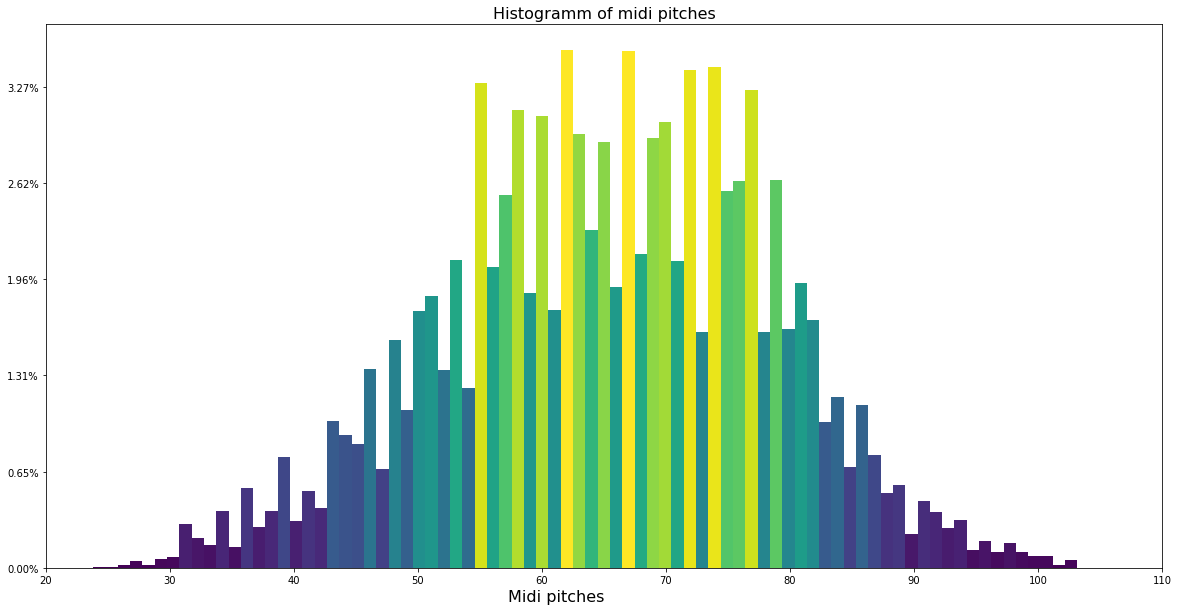

In [0]:

plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([20,110])
# axes.set_ylim([ymin,ymax])
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = plt.hist(np.arange(128), bins=128, weights=midi_statistics)
# We'll color code by height, but you could use any scalar
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# plt.grid(True)
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axes.set_title('Histogramm of midi pitches', fontdict = {'fontsize': 16})
axes.set_xlabel('Midi pitches', fontdict = {'fontsize': 16, 'horizontalalignment': 'right'})
# Now we format the y-axis to display percentage
axes.yaxis.set_major_formatter(PercentFormatter(xmax=np.sum(midi_statistics)))
plt.show()

## ITS TENSORFLOW TIME BABY

### Прямое дискретное преобразование Фурье
$ X_k = \sum\limits_{n=0}^{N-1} x_n e^{-\frac{2 \pi i}{N} k n} = \sum\limits_{n=0}^{N-1} x_n\cdot [\cos(2 \pi k n / N) - i\cdot \sin(2 \pi k n / N)], \qquad (k = 0, \dots, N-1). $

Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:

In [0]:
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
# Эта модель использует при свертке short-time Fourier transform,
# оттого так и называется
class STFT():
    def __init__(self):
        self.learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
        self.mom = tf.placeholder(tf.float32, shape=None, name='learning_rate')
        self.stride = 512
        self.receptive_field = 4096
        self.start_freq = 50
        self.end_freq = 6000
        self.filters_amount= 512
        
        self.frequencies = np.logspace(np.log(self.start_freq),
                                       np.log(self.end_freq),
                                       self.filters_amount,
                                       base=np.e,
                                       endpoint=True)
        
        self.discrete_time = np.arange(self.receptive_field)
        
        # number of lvl1 features
        self.regions = (WINDOW_SIZE - self.receptive_field)/self.stride + 1
        
        # the shape of wsin and wcos is (1, 4096, 1, 512) for now
#         self.wsin = np.empty((1, self.receptive_field, 1, self.filters_amount), dtype=np.float32)
#         self.wcos = np.empty((1, self.receptive_field, 1, self.filters_amount), dtype=np.float32)
#         self.create_filters()
#         self.wsin_var = tf.constant(value=self.wsin, dtype='float32', name="wsin")
#         self.wcos_var = tf.constant(value=self.wcos, dtype='float32', name="wcos")

        
        # 'ph' stands for 'placeholder'
        self.input_X_ph = tf.placeholder('float32', [None, 1, WINDOW_SIZE, 1], name="input_X") # input tensor of shape [batch, in_height, in_width, in_channels]
        self.input_y_ph = tf.placeholder('float32', [None, MIDI_PITCH_AMOUNT], name="input_y")
        self.pred_y_ph = tf.placeholder('float32', [None, MIDI_PITCH_AMOUNT], name="pred_y")



        self.loss = None
        self.accuracy = None
        self.f1_score = None
        self.precision = None
        self.optimizer_step = None
        
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.train_precision_history = []
        self.train_f1_score_history = []
        self.test_loss_history = []
        self.test_accuracy_history = []
        self.test_precision_history = []
        self.test_f1_score_history = []
        
        self.history_metrics = {}
        self.history_parameters = []
        
        self.current_epoch_number = 0
        
        now = datetime.datetime.now()
        self.postfixe_history_filename = now.strftime("_%Y-%m-%d_%H:%M")
                
            
    def create_filters(self):
        for i in np.arange(self.filters_amount):
            current_freq = self.frequencies[i]
            args = 2 * np.pi * current_freq * self.discrete_time / self.receptive_field
            self.wsin[0, :, 0, i] = np.sin(args)
            self.wcos[0, :, 0, i] = np.cos(args)
    
    # filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
    def create_filters_test(self, d,k):
        x = np.linspace(0, 2*np.pi, d, endpoint=False)
        wsin = np.empty((1,d,1,k), dtype=np.float32)
        wcos = np.empty((1,d,1,k), dtype=np.float32)
        start_freq = 50.
        end_freq = 6000.
        num_cycles = start_freq*d/44100.
        scaling_ind = np.log(end_freq/start_freq)/k
        window_mask = 1.0-1.0*np.cos(x)
        for ind in range(k):
            wsin[0,:,0,ind] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
            wcos[0,:,0,ind] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)

        return wsin,wcos
        
        
    def define_graph(self, activation=None):
      
      # =====
        wsin, wcos = self.create_filters_test(self.receptive_field, self.filters_amount)
        self.wsin_var = tf.constant(value=wsin, dtype='float32', name="wsin")
        self.wcos_var = tf.constant(value=wcos, dtype='float32', name="wcos")
      # =====
        
        conv_sin = tf.nn.conv2d(input=self.input_X_ph,
                                filter=self.wsin_var,
                                strides=[1, 1, self.stride, 1],
                                padding="VALID")
        conv_cos = tf.nn.conv2d(input=self.input_X_ph,
                                filter=self.wcos_var,
                                strides=[1, 1, self.stride, 1],
                                padding="VALID")
        
        fourier_values_module_square = tf.square(conv_sin) + tf.square(conv_cos)
        
        # Output tensor the same shape as inputs except the last dimension is of size units.
        dense_layer = tf.layers.Dense(units=MIDI_PITCH_AMOUNT, activation=activation)
        # dense_layer = tf.layers.Dense(units=MIDI_PITCH_AMOUNT)
  
        
        batch_size_ph = tf.shape(self.input_X_ph)[0]
        
        self.pred_y_ph = dense_layer(tf.reshape(tf.log(fourier_values_module_square + 10e-12),
                                                shape=[batch_size_ph, tf.to_int32(self.regions * self.filters_amount)]))
        
        self.loss = tf.reduce_mean(tf.nn.l2_loss(self.input_y_ph - self.pred_y_ph) / MIDI_PITCH_AMOUNT)
        
        y_pred_converted =  tf.cast(tf.math.round(self.pred_y_ph), tf.int32)
        
        self.accuracy = tf.metrics.accuracy(self.input_y_ph, y_pred_converted)
        self.precision = tf.metrics.precision(self.input_y_ph, y_pred_converted)
        self.f1_score = tf.contrib.metrics.f1_score(self.input_y_ph, y_pred_converted)
        
        # self.loss = -tf.reduce_mean(self.input_y_ph * tf.log(self.pred_y_ph + 1e-8) +\
        #                           (1 - self.input_y_ph) * tf.log(1 - self.pred_y_ph + 1e-8))
        # self.loss = f1_loss(self.input_y_ph, self.pred_y_ph)
        
        self.optimizer_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        # self.optimizer_step = tf.train.MomentumOptimizer(self.learning_rate, self.mom).minimize(self.loss)
        
        
        
    def train(self, X, y_true, sess, lr, mom):
        X =  np.reshape(X, (X.shape[0], 1, WINDOW_SIZE, 1))
        loss, precision, f1_score, accuracy, _ = sess.run([self.loss, self.precision, self.f1_score, self.accuracy, self.optimizer_step],
                                                feed_dict={self.input_X_ph: X,
                                                           self.input_y_ph: y_true,
                                                           self.learning_rate: lr,
                                                           self.mom: mom})
        return loss, precision, f1_score, accuracy
      
    def test(self, X, y_true, sess):
        X =  np.reshape(X, (X.shape[0], 1, WINDOW_SIZE, 1))
        loss, precision, f1_score, accuracy = sess.run([self.loss, self.precision, self.f1_score, self.accuracy],
                                                feed_dict={self.input_X_ph: X,
                                                           self.input_y_ph: y_true})
        return loss, precision, f1_score, accuracy

      # НЕ ПРИНИМАЕТ НА ВХОД 1 ВЕКТОР!!! Если очень нужно, то нужно решейпнуть этот вектор в (1, len(вектор))
    def predict(self, X, sess):
      
        X_reshaped = np.reshape(X, (X.shape[0], 1, WINDOW_SIZE, 1))
        y_pred = sess.run(self.pred_y_ph, feed_dict={self.input_X_ph: X_reshaped})
        return y_pred
     
    # n_epoch в данном случае -- это на протяжении скольки эпох указанные параметры были актуальны
    def save_history(self, n_epoch, lr, batch_size): 
        
        self.history_metrics.update({"train_loss_history": self.train_loss_history, "train_accuracy_history": self.train_accuracy_history,
                                     "train_precision_history": self.train_precision_history, "train_f1_score_history": self.train_f1_score_history,
                                     "test_loss_history": self.test_loss_history, "test_accuracy_history": self.test_accuracy_history,
                                     "test_precision_history": self.test_precision_history, "test_f1_score_history": self.test_f1_score_history})
        
        cut = ("epochs: {}-{}\t lr: {}\t batch_size: {}\t".format(self.current_epoch_number, self.current_epoch_number + n_epoch - 1, lr, batch_size) 
               + "stride: {}\t receptive_field: {}\t start_freq: {}\t end_freq: {}\t filters_amount: {}\t".format(self.stride, self.receptive_field,
                                                                                                                  self.start_freq, self.end_freq,
                                                                                                                  self.filters_amount))
        self.history_parameters.append(cut)
        
        np.save("experiment_parameters_history" + self.postfixe_history_filename, self.history_parameters)
        np.save("experiment_metrics_history" + self.postfixe_history_filename, self.history_metrics)
        
        self.current_epoch_number += n_epoch
        
        print("The train history have been saved! Current epoch number: {}".format(self.current_epoch_number))

## Train

In [0]:
batch_size= 64
n_epoch = 100
lr = 0.000001
mom = 0.95

#### Reset everything

In [13]:
tf.reset_default_graph()
sess.close()
tf.trainable_variables()

NameError: ignored

#### Initialize everything

In [23]:
model = STFT()
model.define_graph(activation=tf.nn.sigmoid)
tf.trainable_variables()


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



[<tf.Variable 'dense/kernel:0' shape=(12800, 128) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32_ref>]

In [24]:
sess = tf.InteractiveSession()

# присвоить всем переменным их initial_value
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        
        end = min(start + batch_size, n_samples)
        #f end == n_samples:
        #    break
        batch_idx = indices[start:end]
    
        yield X[batch_idx], y[batch_idx]

In [0]:
def get_epoch_train_parameters(X, y):
  
    loss_arr = []
    precision_arr = []
    accuracy_arr = []
    f1_score_arr = []
    
    for x_batch, y_batch in get_batches(X, y, batch_size):
      
        loss, precision, f1_score, accuracy= model.train(x_batch, y_batch, sess, lr, mom)
        loss_arr.append(loss)
        precision_arr.append(precision)
        accuracy_arr.append(accuracy)
        f1_score_arr.append(f1_score)
        
    return np.mean(loss_arr), np.mean(precision_arr), np.mean(f1_score_arr), np.mean(accuracy_arr)

In [0]:
def get_epoch_test_parameters(X, y):
  
    loss_arr = []
    precision_arr = []
    accuracy_arr = []
    f1_score_arr = []
    
    for x_batch, y_batch in get_batches(X, y, batch_size):
      
        loss, precision, f1_score, accuracy = model.test(x_batch, y_batch, sess)
        loss_arr.append(loss)
        precision_arr.append(precision)
        accuracy_arr.append(accuracy)
        f1_score_arr.append(f1_score)
        
    return np.mean(loss_arr), np.mean(precision_arr), np.mean(f1_score_arr), np.mean(accuracy_arr)
    

In [0]:
def display_history(model):
    plt.figure(figsize=(26, 8))

    plt.subplot(1, 4, 1)
    plt.title("Train and test loss", fontsize=14)
    plt.xlabel("#epoch", fontsize=12)
    plt.ylabel("loss", fontsize=12)
    plt.yscale("log")
    plt.plot(model.train_loss_history, 'b', color='blue', label="train")
    plt.plot(model.test_loss_history, 'b', color='green', label="test")
    plt.legend(fontsize=12)

    
    plt.subplot(1, 4, 2)
    plt.title("Train and test precision", fontsize=14)
    plt.xlabel("#epoch", fontsize=12)
    plt.ylabel("precision", fontsize=12)
    plt.plot(model.train_precision_history, 'b', color='blue', label="train")
    plt.plot(model.test_precision_history, 'b', color='green', label="test")
    plt.legend(fontsize=12)

    
    plt.subplot(1, 4, 3)
    plt.title("Train and test f1-score", fontsize=14)
    plt.xlabel("#epoch", fontsize=12)
    plt.ylabel("f1-score", fontsize=12)
    plt.plot(model.train_f1_score_history, 'b', color='blue', label="train")
    plt.plot(model.test_f1_score_history, 'b', color='green', label="test")
    plt.legend(fontsize=12)

    
    plt.subplot(1, 4, 4)
    plt.title("Train and test accuracy", fontsize=14)
    plt.xlabel("#epoch", fontsize=12)
    plt.ylabel("accuracy", fontsize=12)
    plt.plot(model.train_accuracy_history, 'b', color='blue', label="train")
    plt.plot(model.test_accuracy_history, 'b', color='green', label="test")
    plt.legend(fontsize=12)
    plt.show()

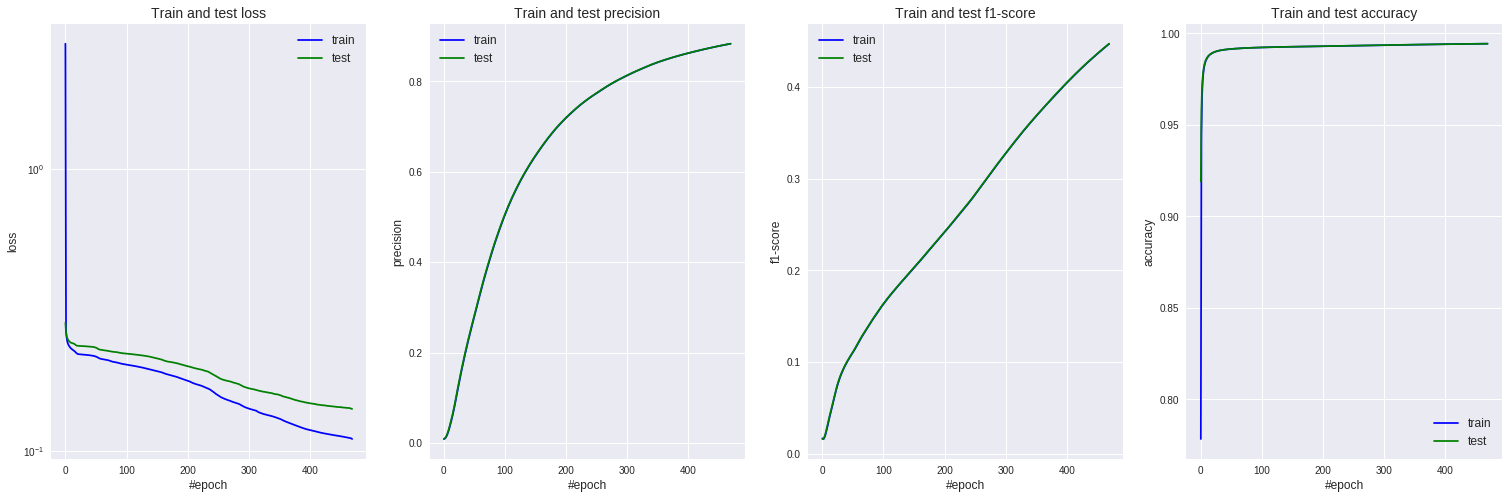

Current train loss: 0.109965
Current test loss: 0.140629
Current train precision: 0.882890
Current test precision: 0.883007
Current train accuracy: 0.994414
Current test accuracy: 0.994416
Current train f1-score: 0.446944
Current test f1-score: 0.447220
The train history have been saved! Current epoch number: 470


In [61]:
for i in range(n_epoch):

    train_epoch_loss, train_epoch_precision, train_epoch_f1_score, train_epoch_accuracy = get_epoch_train_parameters(X_train, y_train)
    test_epoch_loss, test_epoch_precision, test_epoch_f1_score, test_epoch_accuracy = get_epoch_test_parameters(X_test, y_test)

    model.train_loss_history.append(train_epoch_loss)
    model.train_precision_history.append(train_epoch_precision)
    model.train_f1_score_history.append(train_epoch_f1_score)
    model.train_accuracy_history.append(train_epoch_accuracy)

    model.test_loss_history.append(test_epoch_loss)
    model.test_precision_history.append(test_epoch_precision)
    model.test_f1_score_history.append(test_epoch_f1_score)
    model.test_accuracy_history.append(test_epoch_accuracy)
    
    clear_output(wait=True)
    display_history(model)
    
    
    print('Current train loss: %f' % train_epoch_loss)
    print('Current test loss: %f' % test_epoch_loss)
    
    print('Current train precision: %f' % train_epoch_precision)
    print('Current test precision: %f' % test_epoch_precision)

    
    print('Current train accuracy: %f' % train_epoch_accuracy)
    print('Current test accuracy: %f' % test_epoch_accuracy)

    print('Current train f1-score: %f' % train_epoch_f1_score)
    print('Current test f1-score: %f' % test_epoch_f1_score)

model.save_history(n_epoch, lr, batch_size)

    

In [0]:
# a = np.load('experiment_metrics_history2019-04-02 15:14.npy').item()

In [0]:
y_pred = model.predict(X_test[8:10], sess)

In [57]:
np.where(np.round(y_pred[1]) == 1)

(array([34, 35]),)

In [58]:
y_test[9]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
np.where(np.round(y_test[9]) == 1)

(array([34, 35]),)